# **Diaspora Username Classification**

The project aims to assist **Marketers** in identifying individuals from specific Diasporas by analyzing Instagram usernames alone.

While this project could potentially be applicable to any Diaspora, it has specifically focused on the **Indian Diaspora** as its target demographic for analysis.

For this binary classification project, the following algorithms were chosen:
1. **Logistic Regression Algorithm**
2. **Random Forest Algorithm**
3. **Support Vector Machine (SVM) Algorithm**

## Objective
The objective is to categorize usernames into two groups: "True" for Indian usernames and "False" for Non-Indian usernames.

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from nltk.tokenize import SyllableTokenizer

from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

SEED = 42 # set the random seed to 42 for reproducibility

## 1. Data Collection
The data is scraped from [HypeAuditor](https://hypeauditor.com/) using a **Web Scraping Script** written in Python (`scraper.py`).

The script scrapes the top **1000 Most Popular** Instagram Users from:
1. India (`indian_usernames.csv`)
2. **Any** country other than India i.e United States in this case (`non_indian_usernames.csv`)

In [2]:
from scraper import HypeAuditorScraper

scraper = HypeAuditorScraper()
indian_username_df = scraper.scrape(os.getenv("gmail"), os.getenv("password"), india = True)
non_indian_username_df = scraper.scrape(os.getenv("gmail"), os.getenv("password"), india = False)

In [3]:
datasets_folder_path = os.path.join(os.getcwd(), 'datasets')
os.makedirs(datasets_folder_path)
os.chdir(datasets_folder_path)
indian_username_df.to_csv("indian_usernames.csv")
non_indian_username_df.to_csv("non_indian_usernames.csv")

## 2. Data Preprocessing

### 2.1 Merging Datasets and Labelling

Merging the two datasets `indian_usernames.csv` and `non_indian_usernames.csv` into a **single DataFrame**.

Also, **labeling** Indian users as True and non-Indian users as False.

In [4]:
os.chdir('datasets')

indian_usernames_df = pd.read_csv("indian_usernames.csv")
indian_usernames_df["Indian"] = True

non_indian_usernames_df = pd.read_csv("non_indian_usernames.csv")
non_indian_usernames_df["Indian"] = False

df = pd.concat([indian_usernames_df, non_indian_usernames_df], axis = 0, ignore_index = True)
df = df.drop(df.columns[0], axis = 1)
df

,IG Username,Indian
0,cristiano,True
1,leomessi,True
2,arianagrande,True
3,selenagomez,True
4,kendalljenner,True
...,...,...
1995,anastasile,False
1996,liltunechi,False
1997,espn,False
1998,ateez_official_,False


### 2.2 Data Cleaning

**2.2.1 Duplicate Entries**

Removing duplicate entries to prevent skewed distributions in the dataset.

In [5]:
original_size = len(df['IG Username'])
df = df.drop_duplicates(subset=['IG Username']) 
new_size1 = len(df['IG Username'])
print(f'{original_size - new_size1} duplicated entries are removed, {new_size1} entries are retained.')

455 duplicated entries are removed, 1545 entries are retained.


**2.2.2 Numbers and Punctuations**

Regex is employed to eliminate numbers and punctuation from usernames as they typically don't provide useful information for classification purposes. Subsequently, empty entries are dropped from the dataset since some usernames may solely consist of numbers and punctuation marks.


For example:
```
"emi_martinez26" -> "emimartinez"
"505" -> ""
```

In [6]:
df["IG Username"] = df["IG Username"].apply(lambda x: re.sub(r'[\d._]+', '', x))
df = df[df['IG Username'] != ""]
new_size2 = len(df['IG Username'])
print(f'{new_size1 - new_size2} empty entries are removed, {new_size2} entries are retained.')

1 empty entries are removed, 1544 entries are retained.


### 2.3 Tokenization

The usernames are **Syllabically Tokenized**, as this method offers the following advantages:

1. **Lack of Whitespaces**

    Traditional tokenizers reliant on whitespaces may struggle due to the **absence** of whitespaces in the usernames, making syllable-based tokenization more effective.

2. **Usernames are not Sentences**

    Username's structure greatly differs from that of a typical sentence, often lacking sufficient length to extract meaningful "words" as units for **Features**.

3. **Usernames are not composed of English Vocabulary**

    Many usernames contain characters or combinations that aren't part of the English vocabulary. Conventional tokenizers may fail to capture these elements effectively. 

    Even **subword** tokenizers, which tokenize based on prefixes and suffixes, may not suffice.

Employing the **NLTK Syllable Tokenizer** to tokenize the usernames,

In [7]:
tokenizer_model = SyllableTokenizer()
df["Tokenized IG Username"] = df["IG Username"].apply(lambda x: np.array(tokenizer_model.tokenize(x))) 
df["Tokenized IG Username"]
df

,IG Username,Indian,Tokenized IG Username
0,cristiano,True,"[cris, tia, no]"
1,leomessi,True,"[leo, mes, si]"
2,arianagrande,True,"[a, ria, na, gran, de]"
3,selenagomez,True,"[se, le, na, go, mez]"
4,kendalljenner,True,"[ken, dall, jen, ner]"
...,...,...,...
1994,equipedefrance,False,"[e, qui, pe, de, fran, ce]"
1995,anastasile,False,"[a, nas, ta, si, le]"
1996,liltunechi,False,"[lil, tu, nec, hi]"
1998,ateezofficial,False,"[a, tee, zof, fi, cial]"


### 2.4 Encoding

Utilizing **one-hot encoding** (OHE) to transform categorical features (Tokenized Usernames), into binary data for simplifying model interpretation.

In [8]:
unique_syllables = df["Tokenized IG Username"].explode().unique()
for i in unique_syllables:
  df[i] = df["Tokenized IG Username"].apply(lambda syllable_list: int(i in syllable_list))
X = df.iloc[:,3:]
X

,cris,tia,no,leo,mes,si,a,ria,na,gran,...,nio,plets,dsay,yg,riah,siak,jqui,pink,nec,xear
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1995,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1998,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3. Data Exploration

### 3.1 Distribution of Indian and non-Indian Entries

During data collection, the dataset was balanced, with an **equal distribution** of 1000 Indian and 1000 non-Indian entries. However, some of the entries were dropped after data cleaning. 

Therefore, the distribution of data needs to be checked again to avoid **Imbalance**.

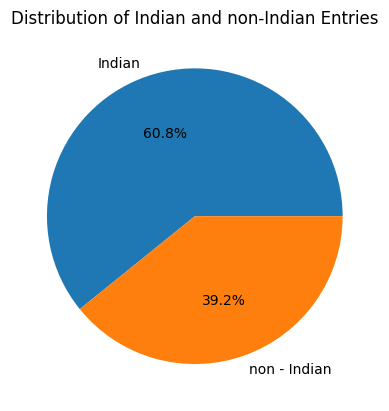

In [9]:
def getData(ind):
  return len(df.loc[(df['Indian'] == ind), 'Indian'])

plt.pie([getData(1), getData(0)], 
        labels = ['Indian', 'non - Indian'], autopct = '%1.1f%%')
plt.title("Distribution of Indian and non-Indian Entries")
plt.show()

In this case, Indian usernames comprise `60.8%` and non-Indian usernames comprise `39.2%` of the entries. 

So, further data processing is not required as data is **Mildly Imbalanced**.

### 3.2 Distribution of Repeated and Unique Syllables

There are 4110 repeated syllables and 2042 unique syllables.


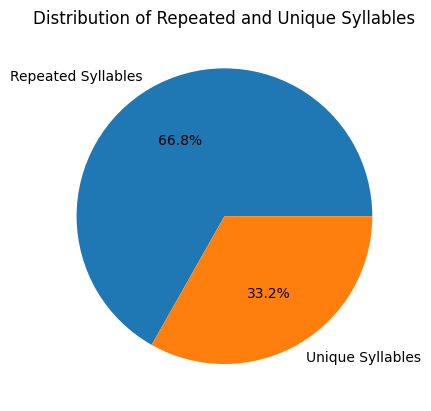

In [10]:
all_syllables = len(df["Tokenized IG Username"].explode())
unique_syllables = len(df["Tokenized IG Username"].explode().unique())
repeated_syllables = all_syllables - unique_syllables

print(f'There are {repeated_syllables} repeated syllables and {unique_syllables} unique syllables.')

plt.pie([repeated_syllables, unique_syllables], 
        labels = ['Repeated Syllables', 'Unique Syllables'], autopct = '%1.1f%%')
plt.title("Distribution of Repeated and Unique Syllables")

plt.show()

`66.8%` of the `4110` syllables are found to be repeated while is considered **positive** for classification purposes.

This is attributed to the ability of repeated syllables to serve as **patterns**, enabling the classification model to generalize usernames rather than memorize unique syllables.

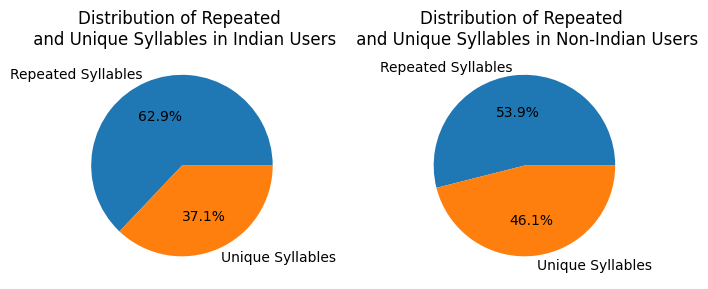

In [11]:
def getData(ind):
  return df.loc[~(df['Indian'] == ind), 'Tokenized IG Username']

fig, ax = plt.subplots(1, 2, figsize=(7, 3))

for i in range(2):
  total_syllables = len(getData(i).explode())
  unique_syllables = len(getData(i).explode().unique())
  repeated_syllables = total_syllables - unique_syllables

  title = "Indian" if i == 0 else "Non-Indian"
  ax[i].pie([repeated_syllables, unique_syllables], 
          labels = ['Repeated Syllables', 'Unique Syllables'], autopct = '%1.1f%%')
  ax[i].set_title(f"Distribution of Repeated \n and Unique Syllables in {title} Users")

plt.tight_layout()
plt.show()

From above, we can see that (`62.9%` Repeated, `37.1%` Unique) for Indian users and (`53.9%` Repeated, `46.1%` Unique) for Non-Indian users.

Overall, Indian users have a higher percentage of repeated syllables. *The classifying models might result in classifying the Indian usernames better as there are more repeated syllables available.*

### 3.4 Visualizing the Potential Patterns between Syllables using t-SNE

Utilized the unsupervised dimensionality reduction technique **t-SNE (t-Distributed Stochastic Neighbor Embedding)** to provide an initial overview of potential underlying patterns within the syllables of usernames.

In this case, dim(2042) is reduced to dim(2).

In [12]:
X.shape

(1544, 2042)

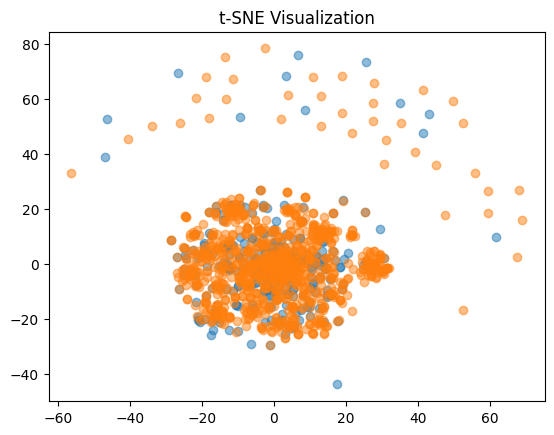

In [13]:
tsne = TSNE(n_components = 2, random_state = SEED)
X_tsne = tsne.fit_transform(X)

df_tsne = pd.DataFrame(data = X_tsne, columns = ['tsne_x', 'tsne_y'])
df_tsne["target"] = df['Indian']

for i in range(2):
  color = ['tab:blue', 'tab:orange']
  plt.scatter(x = df_tsne.loc[(df_tsne['target'] == i), 'tsne_x'], 
              y = df_tsne.loc[(df_tsne['target'] == i), 'tsne_y'], 
              color = color[i], alpha = 0.5)

plt.title("t-SNE Visualization")
plt.show()

From the graph above, no useful insights can be observed as the scatters do not form any distinct clusters.

A possible factor to this might be each syllable in the usernames is treated **independently** (per column) but not the entire username (per row). 

Additionally, the **curse of dimensionality** could be a contributing factor. Reducing dimensionality from 2042 to just 2 can lead to a significant loss of information, particularly given the small dataset size and the likelihood that each feature may only have a few entries.

Therefore, the resulting t-SNE plot may not reveal **distinct clusters or patterns** in the data.

### 3.5 Further Analysis on the Syllables using Linguistics

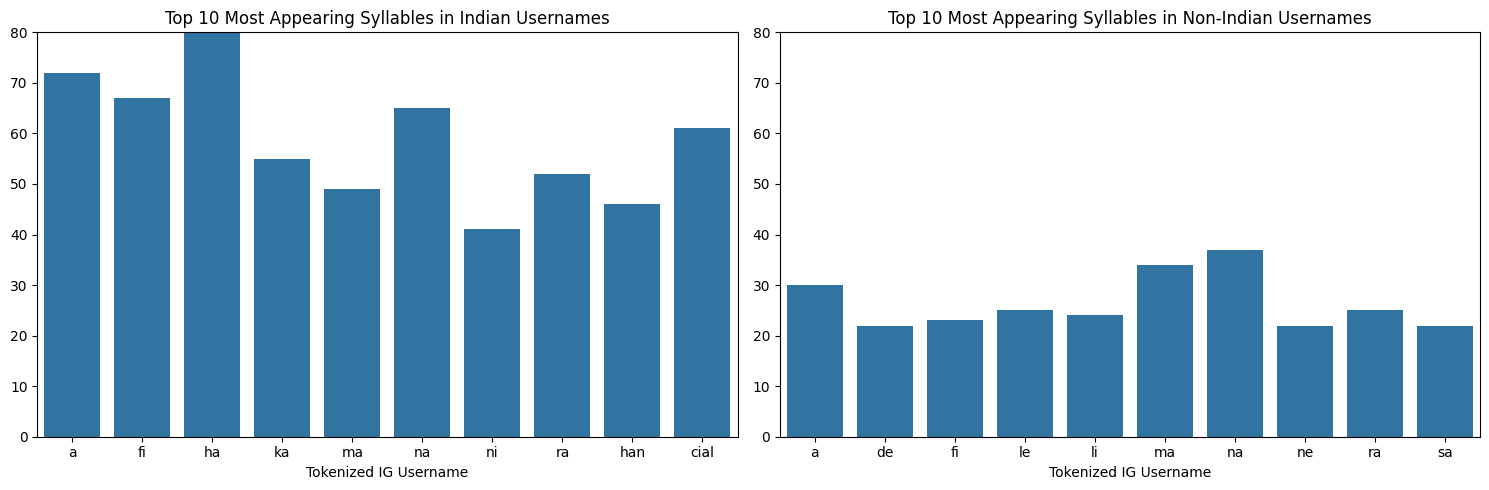

In [14]:
def getData(ind):
  return df.loc[~(df["Indian"] == ind), "Tokenized IG Username"].explode().value_counts() # already descending

fig, ax = plt.subplots(1, 2, figsize = (15, 5))

for i in range(2):
  top_ten_freq = getData(i).head(10).sort_index().sort_index(key = lambda x: x.str.len()) # sort alphabetically then sort by length
  x = top_ten_freq.index
  y = top_ten_freq.values

  title = "Indian" if i == 0 else "Non-Indian"
  sns.barplot(x = x, y = y, ax = ax[i])
  ax[i].set_title(f"Top 10 Most Appearing Syllables in {title} Usernames")
  ax[i].set_ylim(0, 80)

plt.tight_layout()
plt.show()

**Terminologies**:

* Vowels: a, e, i, o, u, y* can be standalone syllables
* Consonants: characters that are not vowels and cannot be a standalone syllables
* Consonant-vowel (CV) syllables: a syllable that contains both vowels and consonants, e.g. 'fi', 'ha', etc.
* Monosyllabic: single/one syllable

*Note: y sometimes can act as a vowel as well*

However, it's crucial to understand that usernames are multifaceted and often extend beyond the user's actual name. For instance, the prevalent occurrence of the "-cial" syllable in Indian usernames serves as evidence of individuals integrating elements beyond personal names, such as the term "official," into their usernames.

## 4. Data Splitting

Splitting the **Feature Matrix** [X] and **Target Vector** [y] into training data `80%` and testing data `20%`.

Splitting the data into two sets helps in preventing **overfitting** by ensuring that the model isn't overly tailored to the training data that hasn't been divided. This approach promotes enhanced generalization to new data.

In [15]:
X = df.iloc[:,3:]
y = df["Indian"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = SEED)

In [16]:
# checking the size
data_name_list = ["X_train", "y_train", "X_test", "y_test"]
arr = [X_train, y_train, X_test, y_test]
for i in range(4):
  print(f"Size of {data_name_list[i]}: {arr[i].shape}")

Size of X_train: (1235, 2042)
Size of y_train: (1235,)
Size of X_test: (309, 2042)
Size of y_test: (309,)


After splitting the dataset, we re-examine its distribution to identify any **skewing** that may have occurred.

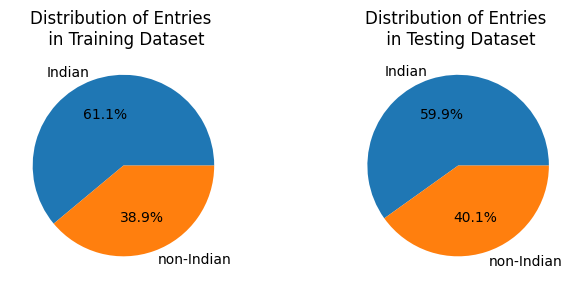

In [17]:
def getData(train, ind):
  return len(y_train[y_train == ind]) if train == 0 else len(y_test[y_test == ind])

fig, ax = plt.subplots(1, 2, figsize=(7, 3))

for i in range(2):
    title = ['Training Dataset', 'Testing Dataset']
    ax[i].pie([getData(i,1), getData(i,0)], labels = ['Indian', 'non-Indian'], autopct='%1.1f%%')
    ax[i].set_title(f"Distribution of Entries \n in {title[i]}")

plt.tight_layout()
plt.show()

The following graphs show that training data and testing data are **mildly imbalanced**.

## 5. Hyperparameter Tuning

### 5.1 Choosing Models for Hyperparameter Tuning

#### Brief Explanation of the Models Chosen:

1. **Logistic Regression (LR)**
    * Assumes data follows a Bernoulli distribution (0 or 1)
    * Maximizes data likelihood with gradient descent
    * Calculates probability using the logistic function

2. **Random Forest (RF)**
    * In a binary decision tree, there are two types of nodes:
        * Conditional node: Sets conditions and branches into another pair of conditional and leaf nodes
        * Leaf node: Contains predicted values or data that satisfy all the conditions
    * Maximizes class separation by selecting from multiple decision trees (ensemble)
    * Creates multiple trees because the conditions set at the root node are arbitrary and can significantly influence the results 
    
3. **Supported Vector Machines (SVM)**
    * Treats the data as vectors in a higher-dimensional space using the kernel trick
    * Maximizes the margin between classes by identifying the optimal hyperplane

#### Visualization of the Decision Boundaries

Though this visualization only gives a partial overview of the decision boundaries, as ```X_test``` is being reduced to 2D with Principal Component Analysis (PCA), it is good enough to show a general idea of how the decision boundaries are formed by different models.

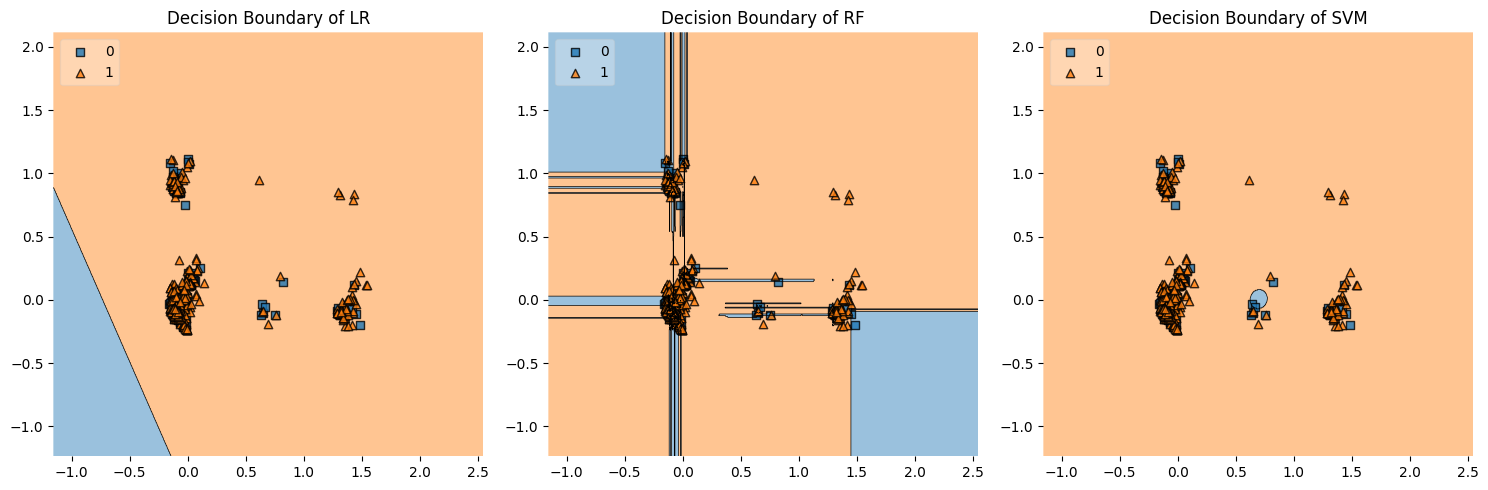

In [18]:
def visualize(X_train, y_train):
  
  models = [('LR', LogisticRegression()),
            ('RF', RandomForestClassifier(random_state=SEED)),
            ('SVM', SVC())]

  fig, ax = plt.subplots(1, 3, figsize = (15, 5)) 

  pca = PCA(n_components = 2)
  re_X_train = pca.fit_transform(X_train)
 
  for i in range(3):    
    clf = models[i][1]
    clf.fit(re_X_train, y_train)
    plot_decision_regions(X = re_X_train, y = y_train.to_numpy().astype(int), clf = clf, legend = 2, ax = ax[i])
    
    name = models[i][0]
    ax[i].set_title(f'Decision Boundary of {name}')

  plt.tight_layout()
  plt.show()

visualize(X_train, y_train)

##### Explanation of the Visualization:

1. **Logistic Regression (LR)** 
    * Division boundary is linear
    * May not effectively capture non-linear relationships

2. **Random Forest (RF)**
    * Division boundary is non-linear
    * Able to capture very complex non-linear relationships 
    * Could be a double-edged sword as it can easily under-fit or over-fit
     
3. **Supported Vector Machines (SVM)**
    * Division boundary is non-linear
    * Able to capture non-linear relationships
    * Effective in handling high-dimensional features
    * Highly sensitive to the choice of kernel and its associated hyperparameters

Overall, **SVM** holds the potential to be the optimal choice if all hyperparameters are finely tuned. However, given the **small dataset size**, it remains crucial to thoroughly assess and compare the performance of all models on this specific dataset.

By tuning and deploying **all three models**, we can ascertain which one delivers the most favorable outcomes and is best suited for the task at hand.

### 5.2 Executing Hyperparameter Tuning

`GridSearchCV()`, an exhaustive search method in **Sklearn**, is used to combine grid search and k-fold cross-validation to tune the hyperparameters.

During this process, hyperparameter tuning, model training, and 5-fold cross-validation are executed **simultaneously**.

All testing hyperparameters are listed in the parameter grid `param_grid` and are determined based on their impact on accuracy.

#### Brief Explanation on the Choice of Testing Hyperparameters

Given the dataset's **small** size, large number of features (2042 syllables), and the possibility that each feature may only have a few entries, the model may exhibit a higher inclination to memorize the limited samples in the training dataset, potentially resulting in poor generalization on unseen data.

Hence, the main priority for  hyperparameter tuning would be to prevent **overfitting**. Common approaches include regularizing the data in Logistic Regression (LR), determining the levels of conditions to run through in Random Forest (RF), and finding the optimal margin in Support Vector Machines (SVM).

In [19]:
def hpTuning(X_train, y_train):

    # three different classification models
    clf = [LogisticRegression(), RandomForestClassifier(random_state = SEED), SVC()]

    param_grid = [{
        'solver': ['liblinear'], # good for small datasets and binary classification; supports l1 and l2 regularization
        'penalty': ['l1', 'l2'], # 2 different regularization methods are used to avoid overfitting by adding a penalty term
    'C': [1, 10, 20] # regularization strength; smaller c greater regularization strength
    },
    {
    'n_estimators': [100, 150], # number of trees in the 'forest'
    'max_depth': [3, 5, 7] # the data run through how many levels of conditions
    },
    {
    'C': [1, 10, 20], # smaller c greater margin
    'gamma': ['auto', 'scale'] # 1 / (n_features * X.var()), 1 / n_features
    }]

    best_clf = []

    for i in tqdm(range(3)):
        grid_search = GridSearchCV(estimator = clf[i], 
                                    param_grid = param_grid[i], 
                                    cv = 5,
                                    scoring = 'accuracy', 
                                    n_jobs = -1) # -1 to enable parallel processing

        grid_search.fit(X_train, y_train) # train
        best_clf.append((grid_search.best_estimator_, 
                        grid_search.best_score_))   

    return best_clf

best_clf = hpTuning(X_train, y_train)
results = pd.DataFrame(data = best_clf, 
                       index = ['LR', 'RF', 'SVM'],
                       columns = ["Hyperparameters", "Accuracy"])

pd.set_option('display.max_colwidth', None)
results

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [02:28<00:00, 49.34s/it]


Hyperparameters  \
LR                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

#### Tuning Results:

1. **Logistic Regression (LR)**
    * The hyperparameter **C** is set to `1`, indicating a relatively small value and thus a strong regularization strength.
    * The model is not overfitting and achieves the highest accuracy of `0.618623`.

2. **Random Forest (RF)**
    * The hyperparameter **max_depth** is set to `3`, indicating a moderately shallow tree with a limited number of conditions
    * However, it achieves the lowest accuracy of `0.610526`, suggesting that random forest may be underfitting the data.

3. **Support Vector Machines (SVM)**
    * The hyperparameter **C** is set to `1`, representing a relatively small value, which implies a large margin between the support vectors.
    * The model is not overfitting and achieves the second-best accuracy of `0.625911`.

Unsurprisingly, SVM exhibits the best performance, while RF fares the worst, possibly due to underfitting or overfitting issues. However, the performance of LR is also noteworthy.

## 6. Model Testing

### 6.1 Confusion Matrix

Visualizing the testing performance of each model in a confusion matrix

|             | Predicted Negative | Predicted Positive |
|-------------|-------------------|-------------------|
| Actual Negative |       True Negative (TN)          |       False Positive (FP)        |
| Actual Positive |       False Negative (FN)          |       True Positive (TP)         |

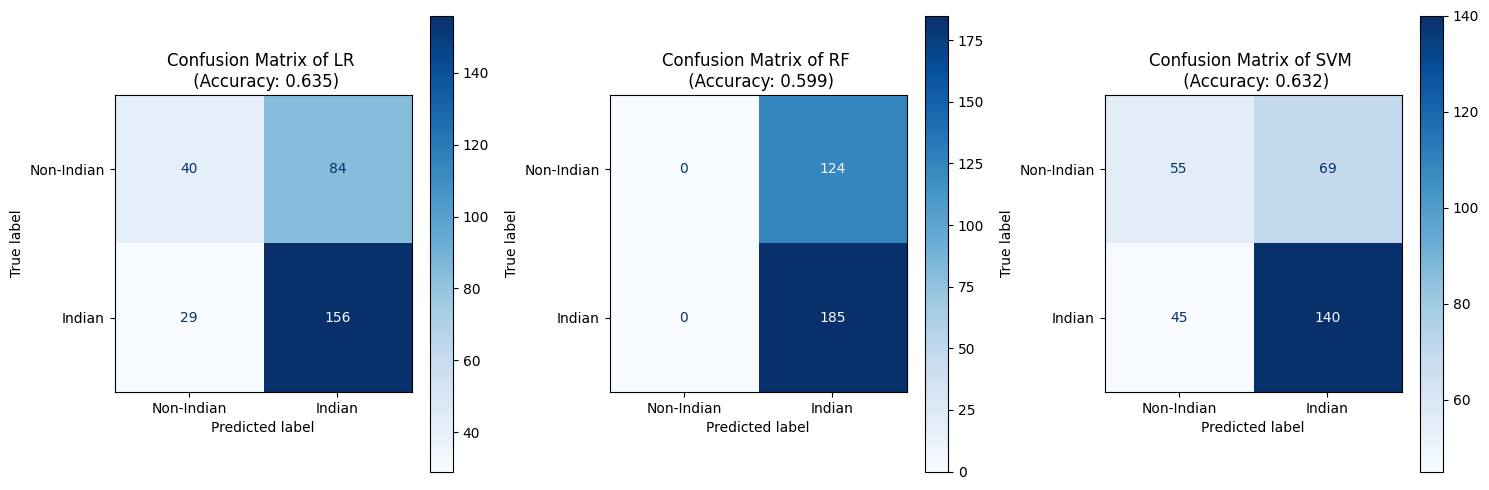

In [20]:
def performance_test(best_clf, X_test, y_test):
  
  model_name = ['LR', 'RF', 'SVM']
  fig, ax = plt.subplots(1, 3, figsize = (15, 5)) 

  for i in range(3):
    y_pred = best_clf[i][0].fit(X_train, y_train).predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
 
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Non-Indian', 'Indian'])
    disp.plot(cmap = 'Blues', ax = ax[i])

    accuracy = math.ceil(accuracy_score(y_test, y_pred)*1000)/1000 # round to 3 dp
    ax[i].set_title(f'Confusion Matrix of {model_name[i]} \n (Accuracy: {accuracy})')

  plt.tight_layout()
  plt.show()

performance_test(best_clf, X_test, y_test)

Testing results have **slightly better** performance than validation results while RF is still the model with the worst performance (0.599).

### 6.2 Classification Report

Showing other evaluation metrics like precision, recall, etc. in a tabular form.

In [21]:
# classification report
model_name = ['LR', 'RF', 'SVM']
for i in range(3):
  y_pred = best_clf[i][0].fit(X_train, y_train).predict(X_test)
  print(f'Classification Report of {model_name[i]}')
  print(classification_report(y_test, y_pred))

Classification Report of LR
              precision    recall  f1-score   support

       False       0.58      0.32      0.41       124
        True       0.65      0.84      0.73       185

    accuracy                           0.63       309
   macro avg       0.61      0.58      0.57       309
weighted avg       0.62      0.63      0.61       309

Classification Report of RF
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       124
        True       0.60      1.00      0.75       185

    accuracy                           0.60       309
   macro avg       0.30      0.50      0.37       309
weighted avg       0.36      0.60      0.45       309

Classification Report of SVM
              precision    recall  f1-score   support

       False       0.55      0.44      0.49       124
        True       0.67      0.76      0.71       185

    accuracy                           0.63       309
   macro avg       0.61      0.60      0.60

Once again, by checking the f1-score (the harmonic mean of precision and recall) of LR or SVM, the f1-score of true is better than false. Both models are better at identifying Indian usernames than Non-Indian usernames. And all the metrics in RF are worse than LR or SVM.

## 7. Conclusion

In summary, this project focuses on classifying Indian Instagram usernames, achieving a **61.2% accuracy** with the **LR** model. It utilizes an unconventional tokenization technique based on syllables, highlighting the significance of the NLTK syllable tokenizer in the classification process